# Exploratory data analysis

In [1]:
# !pip install -r requirements.txt

In [2]:
import pandas as pd

In [3]:
data_frame = pd.read_csv('text copy.csv')

In [4]:
# data_frame['label']

In [5]:
# data_frame.head()

* Note: 0 = sad, 1 = joy, 2 = love, 3 = anger, 4 = fear, 5 = suprise

Before spliting dataset, we need to check the distribution of the 'label' column

In [6]:
# data_frame.label.value_counts()

In [7]:
del data_frame['Unnamed: 0']

In [8]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
import numpy as np

In [9]:
all_labels = Counter(data_frame.label)
all_labels.most_common()

[(1, 141067), (0, 121187), (3, 57317), (4, 47712), (2, 34554), (5, 14972)]

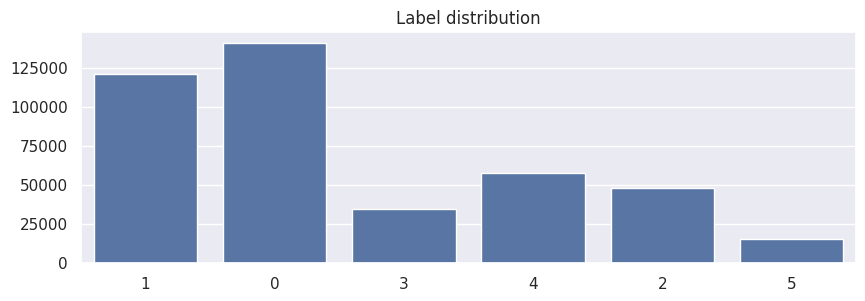

In [10]:
labels, label_counts = zip(*all_labels.most_common())
plt.figure(figsize=(10,3))
ax = sns.barplot(x=list(labels), y=list(label_counts))
ax.set_xticklabels(labels, rotation=0)
plt.title('Label distribution')
plt.show()

In [11]:
def balance_dataset(df, label_ratios):
    """Balances the dataset by downsampling specific labels.

    Args:
        df: The Pandas DataFrame containing the data.
        label_ratios: A dictionary mapping labels to their desired ratios
                      relative to the smallest class.
                      e.g., {0: 1, 1: 1, 2: 0.7, 3: 0.5, 4: 0.6, 5: 0.2}
                      means label 0 and 1 will have the same number of samples
                      (the smallest class size), label 2 will have 70% of
                      that size, label 3 will have 50%, and so on.

    Returns:
        A balanced DataFrame.
    """

    # Find the label with the minimum number of samples
    min_count = df['label'].value_counts().min()

    # Create a new DataFrame to store the balanced data
    balanced_df = pd.DataFrame()

    # Downsample each label based on the specified ratios
    for label, ratio in label_ratios.items():
        label_indices = df[df['label'] == label].index
        num_to_keep = int(min_count * ratio)
        keep_indices = np.random.choice(label_indices, size=num_to_keep, replace=False)
        balanced_df = pd.concat([balanced_df, df.loc[keep_indices]])

    return balanced_df


In [12]:

# Define your desired label ratios:
label_ratios = {0: 1, 1: 1.1, 2: 1, 3: 1, 4: 1.1, 5: 1}  # Example ratios

# Balance the dataset:
data_frame = balance_dataset(data_frame, label_ratios)

In [13]:
# len(data_frame)

In [14]:
data_frame.to_csv('text.csv', index=False)

In [15]:
data_frame = pd.read_csv('text.csv')

In [16]:
# data_frame

In [17]:
data_frame.label.value_counts()

,count
label,
1,16469
4,16469
0,14972
2,14972
3,14972
5,14972


In [18]:
# label = 3
# plt.figure(figsize=(20,8))
# subset = data_frame[data_frame.label == label]
# text = subset.text.values
# cloud = WordCloud(stopwords=STOPWORDS, background_color='black', collocations=True,
#                   width=900, height=500).generate(" ".join(text))
# plt.axis("off")
# plt.imshow(cloud)

# Data preprocessing

Remove null values if exist

In [19]:
# data_frame.isnull().value_counts()

Remove stopwords

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

In [21]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
STOPWORDS = stopwords.words('english')

In [23]:
def clean_text(text, stopwords=STOPWORDS):
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub("", text)

    # Spacing and filters
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text)
    text = re.sub(" +", " ", text)
    text = re.sub("http\S+", "", text)

    return text

In [24]:
original_df = data_frame.copy()
data_frame.text = original_df.text.apply(clean_text)
data_frame.text.values[900]

'im coming understand people feeling rejected see social sarah everywhere go dont see sarah like big crowds really enjoys simple evenings family '

In [25]:
# def lemmatizer(text):
#     lemmatizer = WordNetLemmatizer()
#     text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
#     return text

Stemming

In [26]:
def stemmer(text):
    porter_stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([porter_stemmer.stem(word) for word in text.split()])
    return text

In [27]:
data_frame['text'] = data_frame['text'].apply(stemmer)

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train_df, val_df = train_test_split(data_frame,
                                    test_size=0.2,
                                    stratify=data_frame['label'],
                                    random_state=42)

In [30]:
train_df.label.value_counts()

,count
label,
1,13175
4,13175
5,11978
2,11978
3,11977
0,11977


To check if the data splits have similar distribution, we multiply the value counts of validation_df to 4 (= train size/ validation size)

In [31]:
val_df.label.value_counts() * 4

,count
label,
4,13176
1,13176
3,11980
0,11980
5,11976
2,11976


Since the adjusted value counts of validation_df looks very similar to the value counts of train_df, these two data splits have the same class distribution

TF-IDF

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
X = train_df['text']
y = train_df['label']

In [34]:
tf = TfidfVectorizer(min_df=0.0,max_df=0.98,binary=False,ngram_range=(1,3), sublinear_tf=True)
tf_train = tf.fit_transform(X)

SVM

In [35]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
svm = SVC(C=1, class_weight='balanced', kernel='linear')
svm_model = svm.fit(tf_train, y)

In [ ]:
tf_validation = tf.transform(val_df['text'])

In [ ]:
y_pred = svm_model.predict(tf_validation)

In [ ]:
print(classification_report(val_df['label'], y_pred))

Hyperparameter tuning

In [ ]:
# !pip install scikit-optimize

In [ ]:
# from skopt import BayesSearchCV
# param_space = {
#     'C': [0.1, 0.5, 1, 5, 10, 50, 100],
#     'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
#     'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
#     'class_weight': ['balanced', None],
#     'degree': [2, 3, 4],  # Only matters for poly kernel
#     'coef0': [0.0, 0.1, 0.5]  # Important for poly and sigmoid kernels
# }
# bayes_search = BayesSearchCV(SVC(), param_space, n_iter=10, cv=5, verbose=2)
# bayes_search.fit(tf_train, y)

Test model

In [ ]:
def preprocess(input_text):
    cleaned_text = clean_text(input_text)
    stemmed_text = stemmer(cleaned_text)
    tf_test = tf.transform([stemmed_text])
    return tf_test

In [ ]:
predictions = []

for text in val_df.text.values:
    processed_text = preprocess(text)
    prediction = svm_model.predict(processed_text)
    predictions.append(prediction[0])

In [ ]:
print(classification_report(val_df.label.values, predictions))

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(val_df.label.values, predictions)

In [ ]:
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['sad', 'joy', 'love', 'anger', 'fear', 'surprise'],
            yticklabels=['sad', 'joy', 'love', 'anger', 'fear', 'surprise'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()